Importing Libraries

In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import seaborn as sns
from tensorflow import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#!pip install pmdarima
from pmdarima import auto_arima

Reading the Data

In [280]:
df = pd.read_csv("PJME_hourly.csv")
df.index = pd.to_datetime(df['Datetime'])
df.drop(columns="Datetime", inplace = True)
df = df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


Visualizing the raw data

Feature Extraction from the data

In [281]:
def feature_extractor(df):
  df = df.copy()
  df["hour"] = df.index.hour
  df["week"] = df.index.week
  df["month"] = df.index.month
  df["quaterly"] = df.index.quarter
  df["year"] = df.index.year
  print(df.head())
  return df

<Axes: title={'center': 'Energy Data Distribution'}, ylabel='Frequency'>

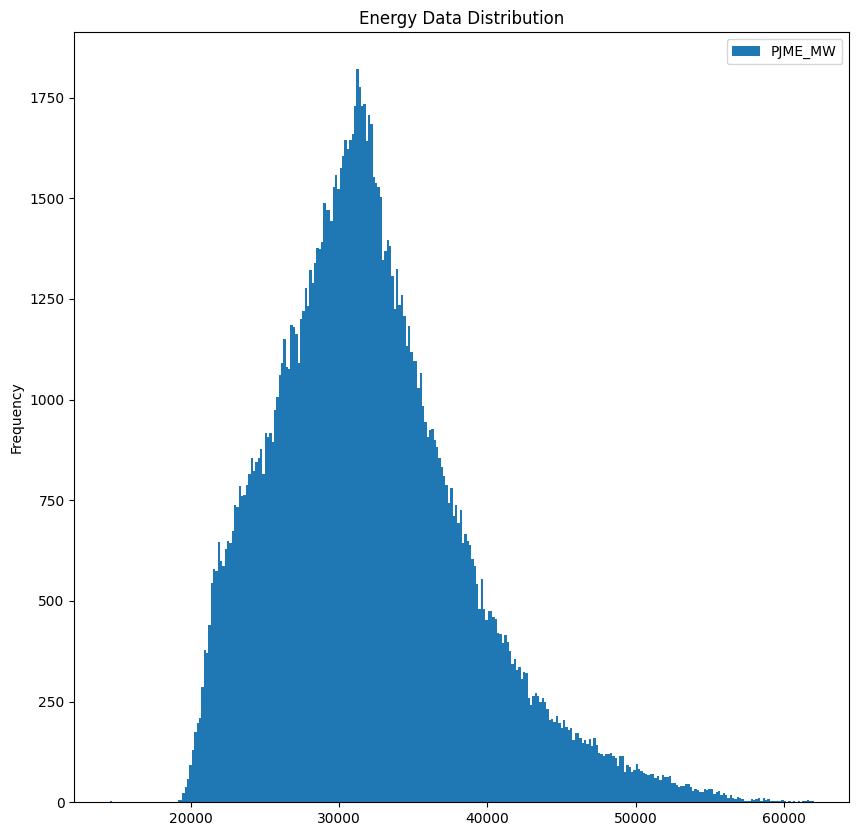

In [282]:
df.plot.hist(figsize=(10, 10), bins=300, title="Energy Data Distribution")

Split the data

                     PJME_MW  hour  week  month  quaterly  year
Datetime                                                       
2002-01-01 01:00:00  30393.0     1     1      1         1  2002
2002-01-01 02:00:00  29265.0     2     1      1         1  2002
2002-01-01 03:00:00  28357.0     3     1      1         1  2002
2002-01-01 04:00:00  27899.0     4     1      1         1  2002
2002-01-01 05:00:00  28057.0     5     1      1         1  2002
                     PJME_MW  hour  week  month  quaterly  year
Datetime                                                       
2015-05-23 00:00:00  24015.0     0    21      5         2  2015
2015-05-23 01:00:00  22231.0     1    21      5         2  2015
2015-05-23 02:00:00  21079.0     2    21      5         2  2015
2015-05-23 03:00:00  20404.0     3    21      5         2  2015
2015-05-23 04:00:00  20022.0     4    21      5         2  2015


<ipython-input-281-853f84b33434>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df.index.week
<ipython-input-281-853f84b33434>:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df["week"] = df.index.week


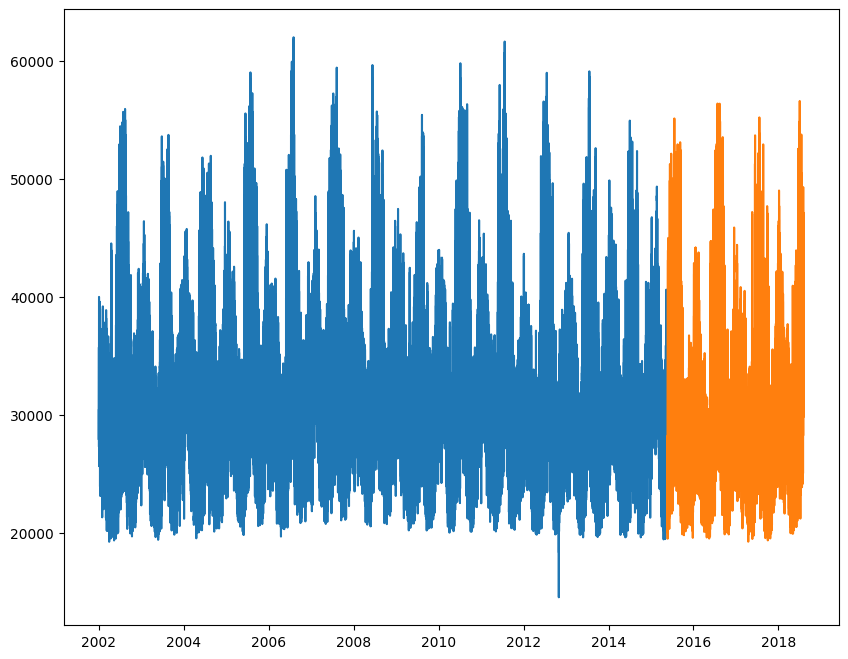

In [283]:
train = feature_extractor(df.loc[df.index<"2015-05-23"])
test = feature_extractor(df.loc[df.index>="2015-05-23"])

plt.plot(train["PJME_MW"])
plt.plot(test["PJME_MW"])

In [284]:
train

,PJME_MW,hour,week,month,quaterly,year
Datetime,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002
2002-01-01 02:00:00,29265.0,2,1,1,1,2002
2002-01-01 03:00:00,28357.0,3,1,1,1,2002
2002-01-01 04:00:00,27899.0,4,1,1,1,2002
2002-01-01 05:00:00,28057.0,5,1,1,1,2002
...,...,...,...,...,...,...
2015-05-22 19:00:00,28455.0,19,21,5,2,2015
2015-05-22 20:00:00,27947.0,20,21,5,2,2015
2015-05-22 21:00:00,28372.0,21,21,5,2,2015


Visualizing the importance of the Features

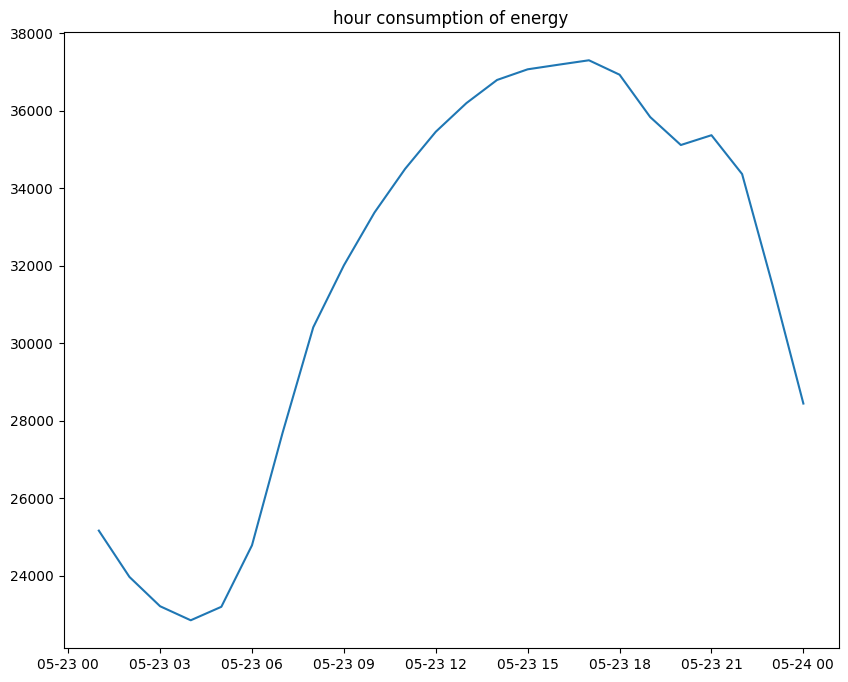

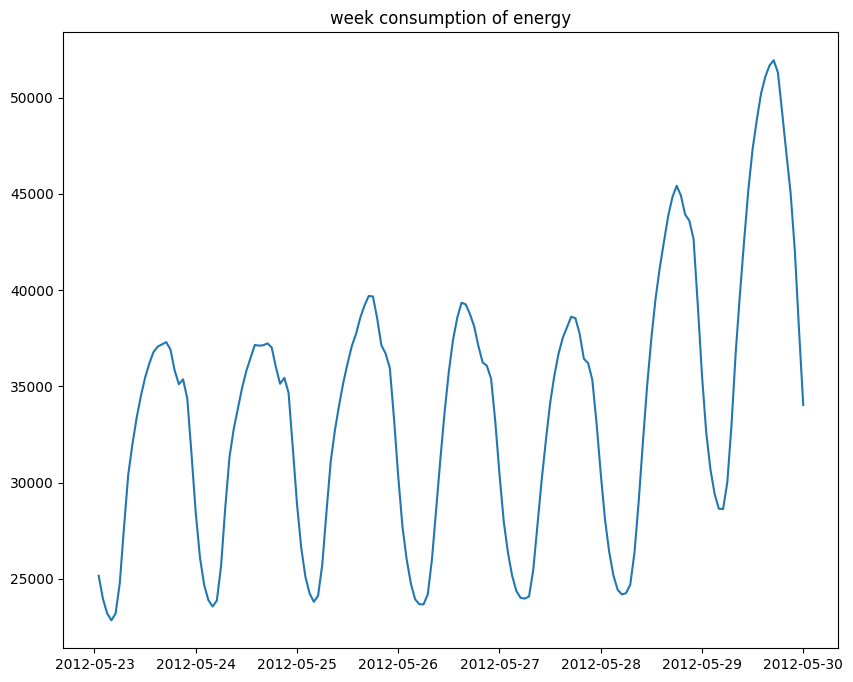

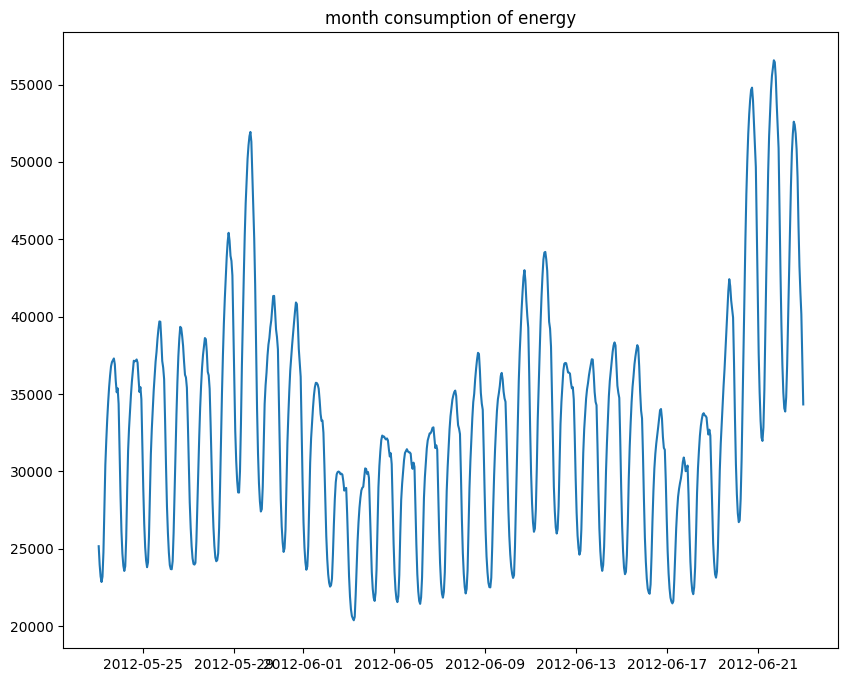

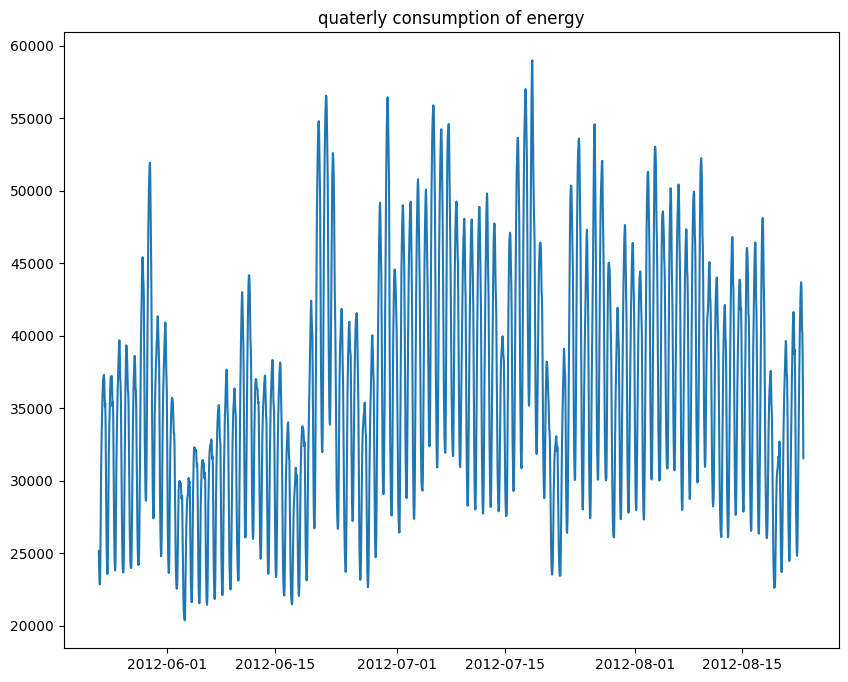

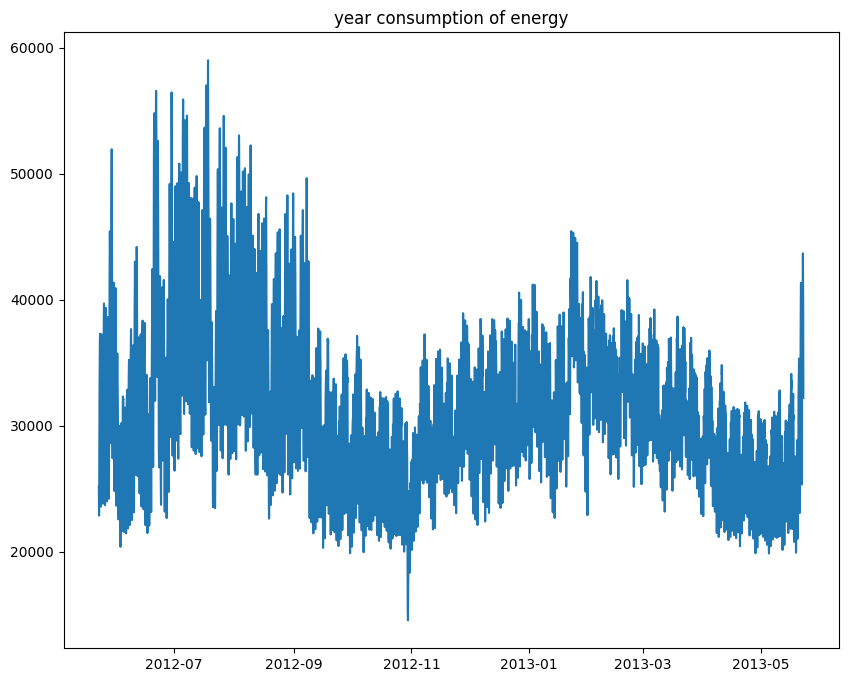

In [285]:
def visualizing_features(start_date, end_date, parameter):
  plt.plot(figsize=(20, 16))
  range = df.loc[(df.index>start_date)&(df.index<=end_date)]
  plt.plot(range.index, range)
  plt.title(f"{parameter} consumption of energy")
  plt.show()

visualizing_features("2012-05-23", "2012-05-24", "hour")
visualizing_features("2012-05-23", "2012-05-30", "week")
visualizing_features("2012-05-23", "2012-06-23", "month")
visualizing_features("2012-05-23", "2012-08-23", "quaterly")
visualizing_features("2012-05-23", "2013-05-23", "year")


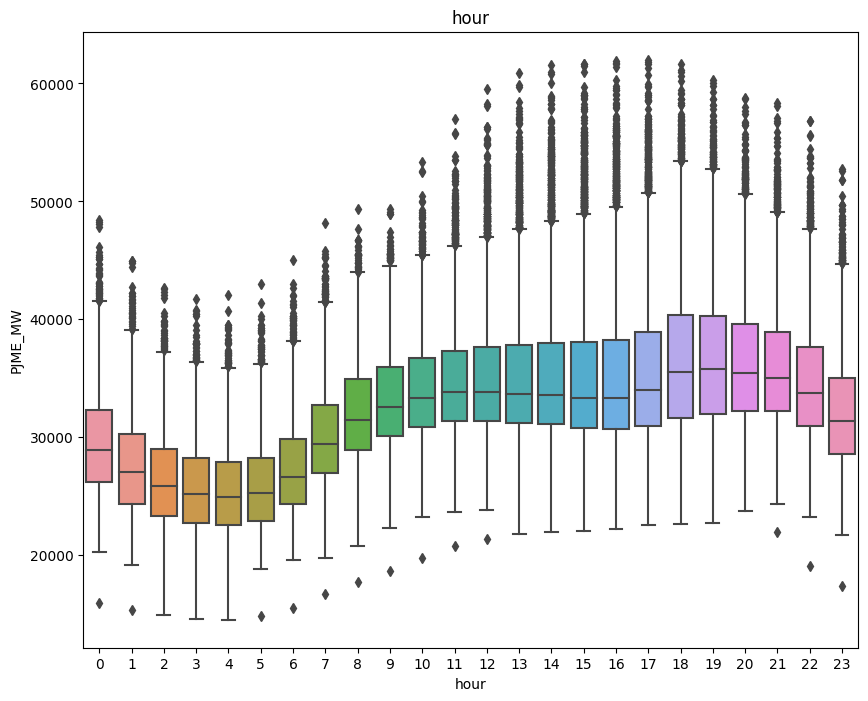

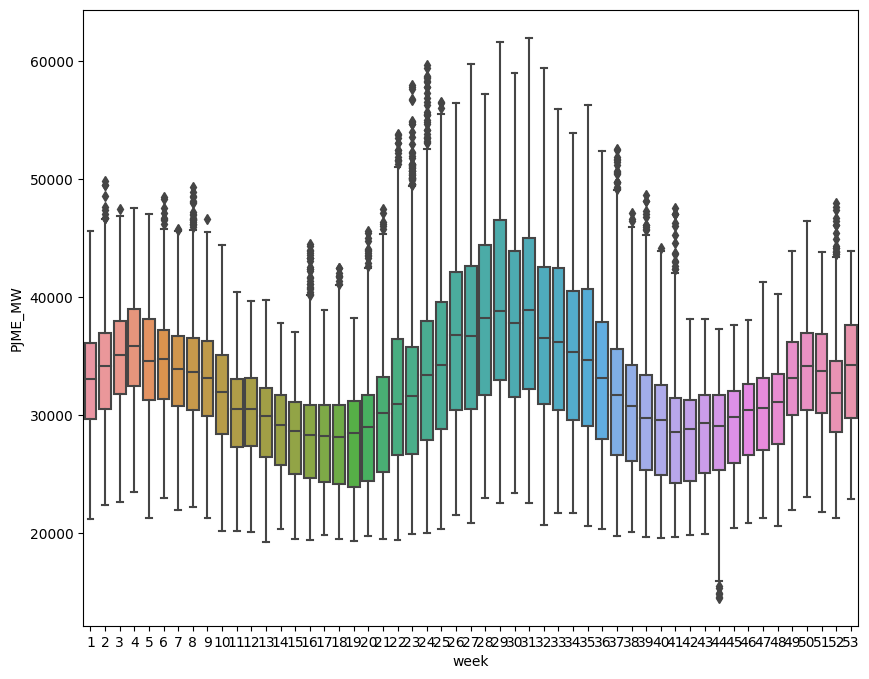

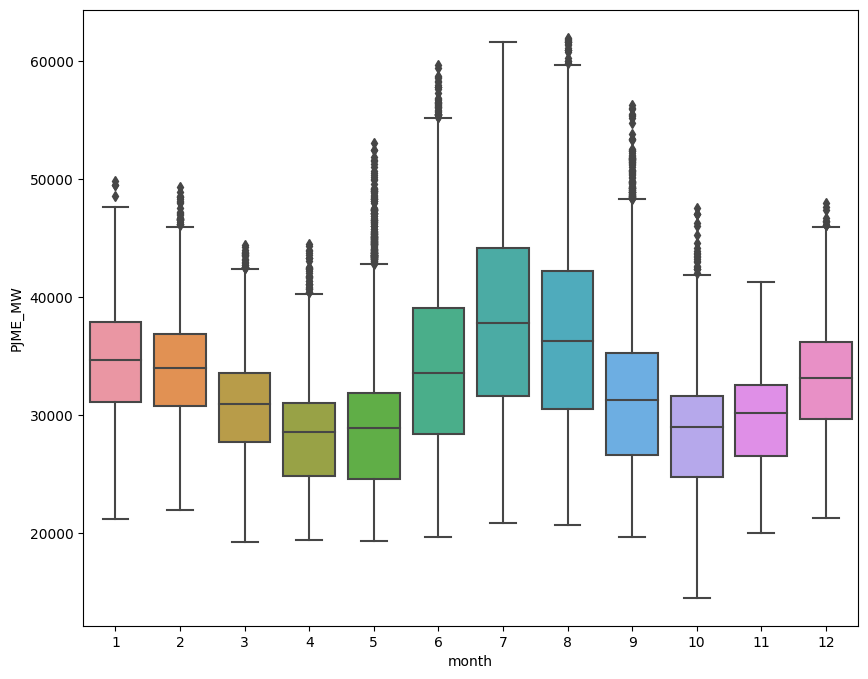

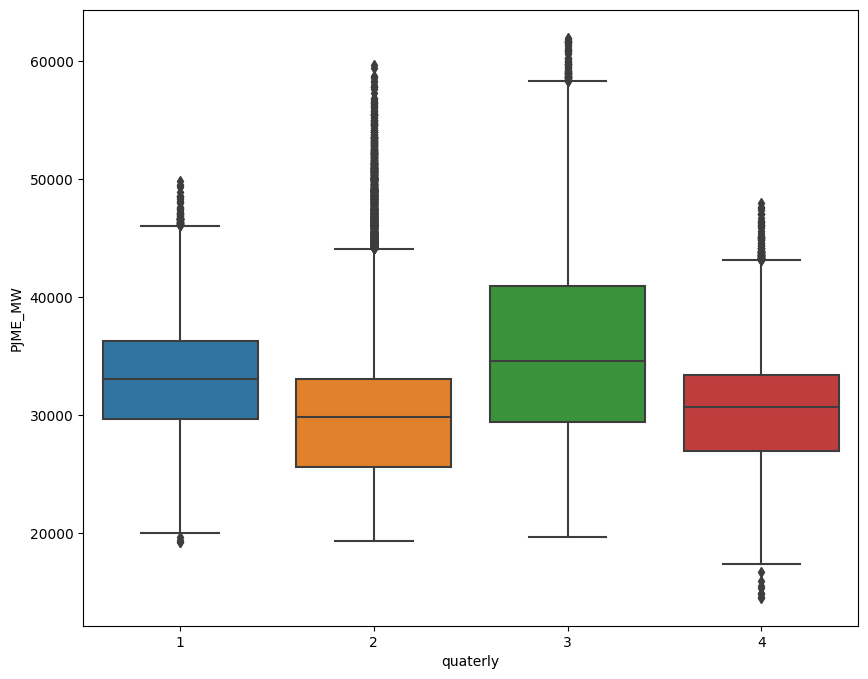

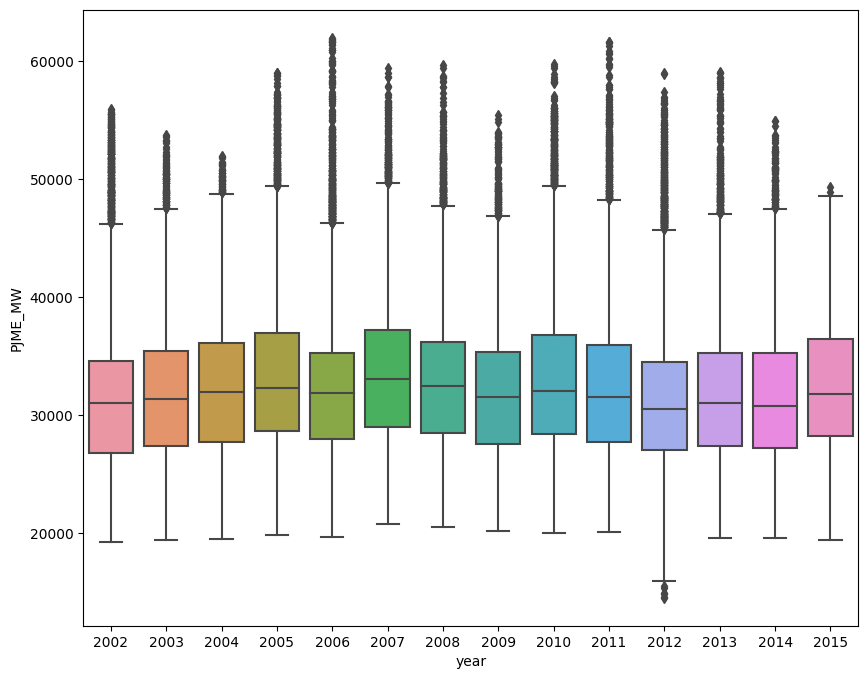

In [286]:
features = ["hour", "week", "month", "quaterly", "year"]

fig, ax = plt.subplots(figsize=(10, 8))


for i in features:
  sns.boxplot(data=train, x =i, y = "PJME_MW")
  ax.set_title(i)
  plt.show()



Spliting the Data into features (x) and targets (Y)

In [287]:
x_train = train[features]
x_test = test[features]

scale = StandardScaler()
y_train = scale.fit_transform(np.expand_dims(train["PJME_MW"], axis=-1))
y_test = scale.transform(np.expand_dims(test["PJME_MW"], axis=-1))

Providing a Choice between XGboost, Lstm and Arima

In [288]:
options = ("XGBoost", "Arima", "Lstm")
while True:
  choice = input("Enter a choice between XGBoost or Lstm or Arima: ")
  print(f"You have opted for {choice}")
  if choice not in options:
    print("Please check the option choosen \n")
    continue
  else:
    print(f"Executing {choice}\n")
    break
print("Going for model training")

Enter a choice between XGBoost or Lstm or Arima: Arima
You have opted for Arima
Executing Arima

Going for model training


Functions to train the mdodels choosen

In [289]:
class XGBoost:

  def __init__(self, x_train, y_train, x_test, y_test):
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    model = xgb.XGBRegressor(n_estimators=500, early_Stopping=100, learning_rate=0.01)
    model.fit(self.x_train, self.y_train, eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)], verbose=100)

    importance = pd.DataFrame(data= model.feature_importances_, index = model.feature_names_in_, columns=["importance"])
    importance.sort_values("importance").plot(kind="barh", title="Importance of the Features")
    plt.show()
    y_pred = model.predict(self.x_test)
    return y_pred

  def plot(self, y_pred):
    plt.plot(self.x_test.index, self.y_test)
    plt.plot(self.x_test.index, y_pred)
    plt.legend(["y_test", "y_pred"])
    plt.title("Energy forecast")
    plt.show()

In [290]:
class Lstm:

  def __init__(self, x_train, y_train, x_test, y_test):
    self.test = x_test
    self.x_train = np.expand_dims(x_train, axis=-1)
    self.x_test = np.expand_dims(x_test, axis=-1)
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (self.x_train.shape[1], 1)))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(LSTM(units = 10))
    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(self.x_train, self.y_train, batch_size=24, epochs=50)
    return regressor.predict(self.x_test)

  def plot(self, y_test_pred):
    plt.plot(self.test.index, self.y_test)
    plt.plot(self.test.index, y_test_pred)
    plt.legend(["y_test", "y_pred"])
    plt.title("Energy forecast From LSTM")
    plt.show()

In [291]:
class Arima:

  def __init__(self, x_train, y_train, x_test, y_test):
    self.x_train = x_train
    self.x_test = x_test
    self.y_train = y_train
    self.y_test = y_test

  def train_model(self):
    # Seasonality
    seasonality = seasonal_decompose(self.y_train, period=24)
    rcParams['figure.figsize'] = (10, 8)
    fig = seasonality.plot()
    plt.show()

    # Correlation
    plot_acf(y_train, lags=30)
    plt.show()
    plot_pacf(y_train, lags=30)
    plt.show()

    # auto arima
    model= auto_arima(train["PJME_MW"], min_p=1, max_p=3, start_q=0, max_q=1, trace=True, njpbs=-1, maxiters=5)
    return pd.DataFrame(model.predict(n_periods=len(test["PJME_MW"])))

  def plot(self, y_pred):
    plt.plot(train["PJME_MW"].index, train["PJME_MW"].values)
    plt.plot(test["PJME_MW"].index, test["PJME_MW"].values)
    plt.plot(test["PJME_MW"].index, y_pred.values)
    plt.title("Predictions from Statistical model ARIMA")
    plt.show()

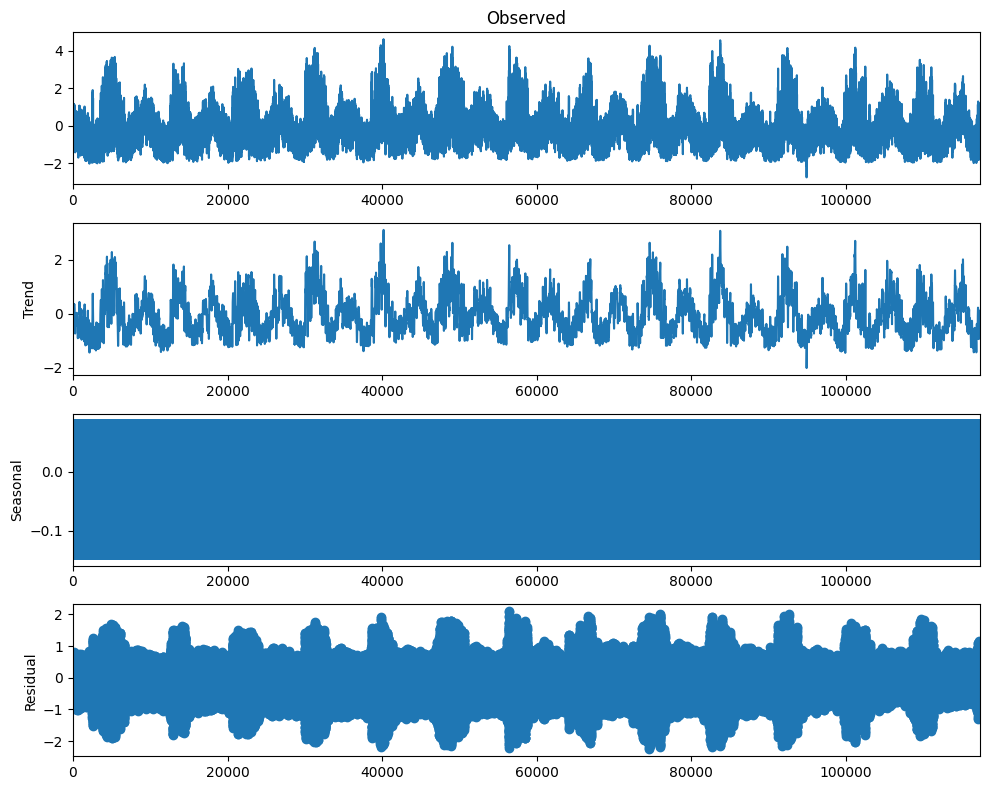

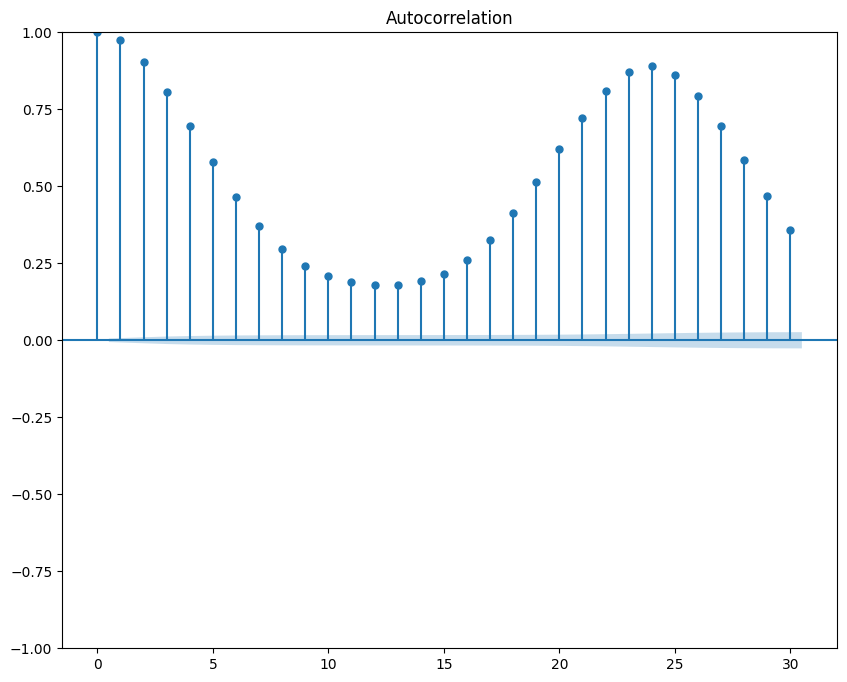

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


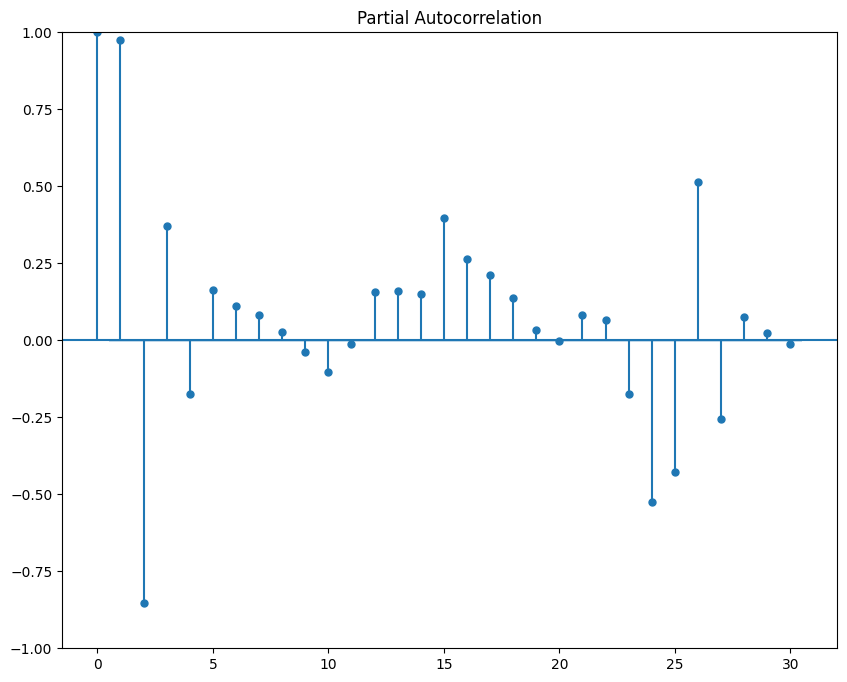

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1881497.950, Time=16.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2044222.632, Time=2.52 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1909135.662, Time=8.84 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1936426.311, Time=33.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2044220.633, Time=2.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1878609.894, Time=21.82 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1880123.405, Time=44.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1878607.895, Time=10.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1880121.407, Time=19.40 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1881495.951, Time=4.99 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1909133.662, Time=4.21 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0]          
Total fit time: 168.046 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


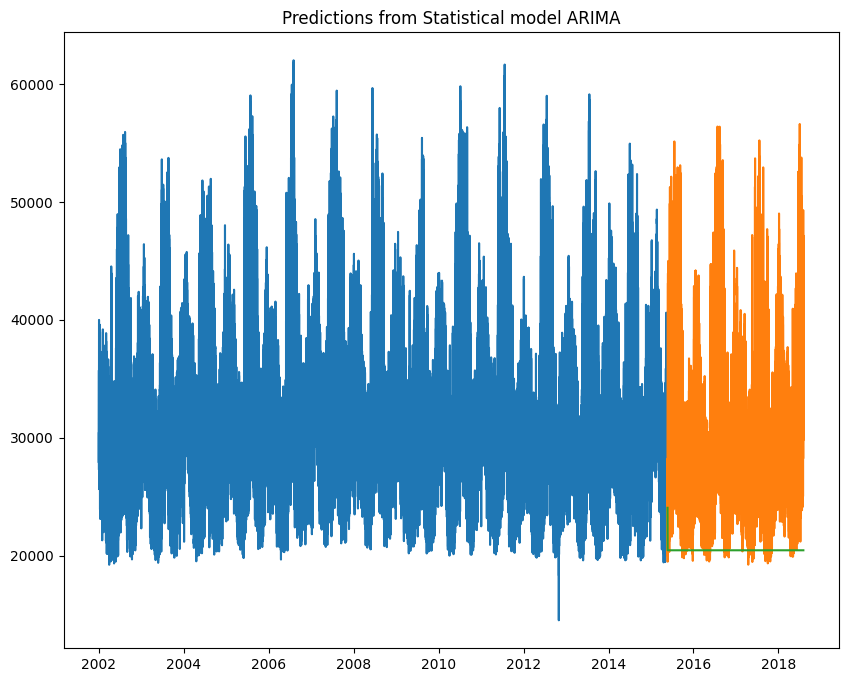

Executed: Arima
Error in the prediction: 4393.516942639405


In [292]:
mapping = {'XGBoost' : XGBoost, 'Lstm' : Lstm, 'Arima': Arima}
process = mapping[choice](x_train, y_train, x_test, y_test)
y_test_pred = process.train_model()
process.plot(y_test_pred)

if choice == "Lstm":
  pred = y_test_pred

else:
  pred = (np.array(y_test_pred)).reshape(-1, 1)

error = mape(np.array(test["PJME_MW"]).reshape(-1, 1), scale.inverse_transform(pred))

print(f"Executed: {choice}")
print(f'Error in the prediction: {error}')
